## Monkey Species classifier

In [348]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [316]:
!cd data/monkeys; ls

models		   tmp	     training.zip  validation.zip
monkey_labels.txt  training  validation


In [317]:
PATH = "data/monkeys/"

In [318]:
df = pd.read_csv(f'{PATH}monkey_labels.txt')
#remove the whitespace around the labels
df['Label'] = df['Label'].str.strip()
df.columns = df.columns.str.strip()

def get_title(category):
    df[df['Label'] == category]['Common Name']
    
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [319]:
os.listdir(PATH)

['training',
 'validation',
 'monkey_labels.txt',
 'models',
 'training.zip',
 'tmp',
 'validation.zip']

In [320]:
os.listdir(f'{PATH}training')

['n0', 'n2', 'n9', 'n6', 'n8', 'n4', 'n7', 'n5', 'n3', 'n1']

In [321]:
files = os.listdir(f'{PATH}training/n0')[:5]
files

['n0144.jpg', 'n0163.jpg', 'n0170.jpg', 'n0124.jpg', 'n0159.jpg']

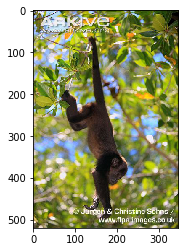

In [322]:
img = plt.imread(f'{PATH}training/n0/{files[0]}')
plt.imshow(img)

In [323]:
img.shape

(520, 347, 3)

In [324]:
sz=224

In [325]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), trn_name='training',val_name='validation')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      1.308931   0.301165   0.978125  
    1      0.688264   0.109749   0.9875                    



[0.10974942, 0.9875]

In [326]:
learn.save('1_lastlayer')

In [327]:
learn.load('1_lastlayer')

In [328]:
data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [329]:
learn.unfreeze()

In [330]:
lr=np.array([1e-4,1e-3,1e-2])

In [331]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.141875   0.088      0.9875    
    1      0.122157   0.062817   0.9875                    
    2      0.109447   0.062438   0.990625                  



[0.062437795, 0.990625]

In [332]:
learn.save('2_lastlayer')

In [333]:
learn.load('2_lastlayer')

## Investigating what is going wrong

In [343]:
# source: fast.ai dog-breed course
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])   

def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 3, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# def plot_val_with_title(idxs, title):
#     imgs = [load_img_id(data.val_ds,x) for x in idxs]
#     title_probs = [probs[x] for x in idxs]
#     print(title)
#     return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


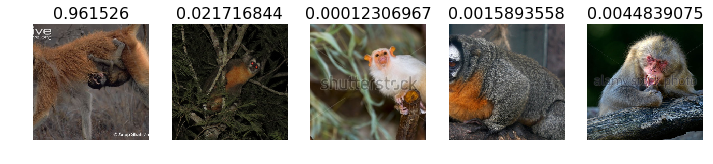

In [335]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

[[26  0  0  0  0  0  0  0  0  0]             
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0]
 [ 0  0  1  0  0 27  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [ 1  0  0  0  0  0  0  0  0 25]]


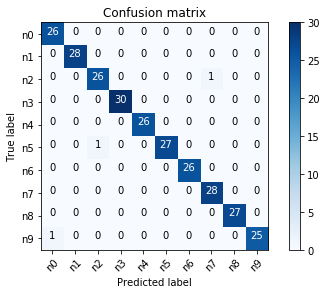

In [336]:
from sklearn.metrics import confusion_matrix
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Only three incorrect!

Incorrectly classified


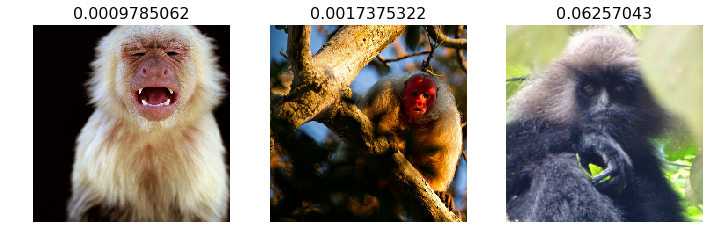

In [344]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

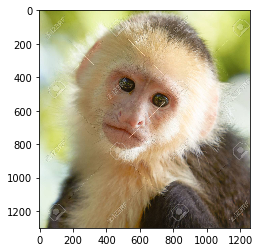

In [345]:
file = os.listdir(f'{PATH}training/n5')[0]
img = plt.imread(f'{PATH}training/n5/{file}')
plt.imshow(img)

^^ what it actually is

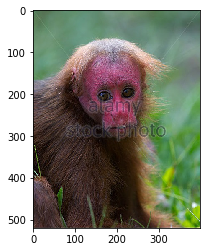

In [346]:
file = os.listdir(f'{PATH}training/n2')[1]
img = plt.imread(f'{PATH}training/n2/{file}')
plt.imshow(img)

^^ what it is predicted as

Even a human could make that mistake...